In [ ]:
# Import needed dependencies

!pip install ultralytics
!pip install rasterio
import ultralytics
import rasterio
import numpy as np
import yaml
import torch
from collections import OrderedDict
import os
import glob
from ultralytics import YOLO
ultralytics.checks()

In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np

def combine_sar_channels(vv_path, vh_path, output_path):
    # Open the VV polarization file
    with rasterio.open(vv_path) as vv:
        vv_data = vv.read(1)  # Read the first band
        vv_meta = vv.meta  # Get metadata for the VV file

    # Open the VH polarization file
    with rasterio.open(vh_path) as vh:
        vh_data = vh.read(1)  # Read the first band

    # Check if the dimensions match
    if vv_data.shape != vh_data.shape:
        raise ValueError("The dimensions of VV and VH images do not match.")

    # Stack VV and VH into a single multi-channel array
    combined_data = np.stack((vv_data, vh_data), axis=0)

    # Update metadata for the combined file
    combined_meta = vv_meta.copy()
    combined_meta.update({
        "count": 2,  # Number of bands (VV and VH)
        "dtype": combined_data.dtype.name  # Ensure the data type matches
    })

    # Write the combined file
    with rasterio.open(output_path, "w", **combined_meta) as dst:
        dst.write(combined_data)


In [ ]:
import json
import os
import rasterio

# Boat-related class IDs based on your mappings
# We convert these to a 0-9 index system for YOLO to accept them
boat_classes = {
    40,  # Maritime vessel
    41,  # Motorboat
    42,  # Sailboat
    44,  # Tugboat
    45,  # Barge
    47,  # Fishing Vessel
    49,  # Ferry
    50,  # Yacht
    51,  # Container Ship
    52   # Oil Tanker
}

# Assuming geojson is in the same folder, modify if needed
with open('/content/drive/MyDrive/ShipClassfication/EO_Train/train_labels.geojson', 'r') as file:
    data = json.load(file)

# Should be the path to the train_images, can be relative path
folder_path = "/content/drive/MyDrive/ShipClassfication/EO_Train"

for feature in data['features']:
    # Get relevant info (making sure numbers involved in calculations are int's)
    image_name = feature['properties']['image_id']
    min_x, min_y, max_x, max_y = [int(x) for x in feature['properties']['bounds_imcoords'].split(',')]
    classification = feature['properties']['type_id']

    # Skip if the classification is not in the list of boat-related classes
    if classification not in boat_classes:
        continue

    # Ignore if image is not in the folder
    image_path = os.path.join(folder_path, image_name)
    if not os.path.exists(image_path):
        continue

    # Load linked image to get dimensions
    try:
        image = rasterio.open(image_path)
        img_height, img_width = image.height, image.width
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        continue

    # Get the relative coordinates for the bounding box in center point width and height
    bbox_width = max_x - min_x
    bbox_height = max_y - min_y
    bbox_x = (min_x + bbox_width / 2) / img_width
    bbox_y = (min_y + bbox_height / 2) / img_height
    bbox_width /= img_width
    bbox_height /= img_height

    # Add bbox to YOLO label txt
    label_file_path = os.path.join(folder_path, image_name.replace('.tif', '.txt'))
    with open(label_file_path, 'a+') as label_file:
        label_file.write(f"{classification} {bbox_x} {bbox_y} {bbox_width} {bbox_height}\n")


In [ ]:
# Remove duplicate labels
import os

def process_yolo_labels(folder_path):
    """
    Processes all YOLO label files in the specified folder:
    1. Removes duplicate lines in each label file.
    2. Changes all instances labeled as class 10 to class 6.

    Args:
        folder_path (str): Path to the folder containing YOLO label files.
    """
    for filename in os.listdir(folder_path):
        print(f"processing {filename}")
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()

            # Remove duplicates and replace class 10 with class 6
            processed_lines = set()
            for line in lines:
                # Normalize the line for more robust duplicate detection:
                line = line.strip().lower()  # Remove leading/trailing whitespace, convert to lowercase
                parts = line.split()
                if len(parts) > 0 and parts[0] == '10':
                    parts[0] = '6'
                processed_lines.add(" ".join(parts))

            # Write back the processed lines to the file
            with open(file_path, 'w') as file:
                file.write("\n".join(processed_lines) + "\n")

if __name__ == "__main__":
    folder_path = "/content/drive/MyDrive/ShipClassfication/EO_Train_Split2"
    if os.path.isdir(folder_path):
        process_yolo_labels(folder_path)
        print("Processing complete.")
    else:
        print("Invalid folder path.")

In [ ]:
import os
import glob
import rasterio

# label classifications here https://challenge.xviewdataset.org/challenge-evaluation
boat_classes = [40, 41, 42, 44, 45, 47, 49, 50, 51, 52, 49]
big_boats = [0, 2, 3, 5, 7, 8, 9]

# Create a mapping for reindexing classes starting from 0
class_mapping = {cls: 0 for idx, cls in enumerate(boat_classes)}

def split_images_and_labels(image_path, label_path, output_dir, grid_size):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Use rasterio to read the image
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = src.height, src.width

    # Load YOLO labels
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Parse YOLO labels
    bounding_boxes = []
    for label in labels:
        data = label.strip().split()
        cls, x_center, y_center, bbox_width, bbox_height = map(float, data)
        # Only include labels for boat classes
        if int(cls) in boat_classes:
            bounding_boxes.append([class_mapping[int(cls)], x_center, y_center, bbox_width, bbox_height])

    # Split the image into smaller patches
    rows, cols = grid_size
    patch_height, patch_width = height // rows, width // cols

    patch_counter = 0
    for i in range(rows):
        for j in range(cols):
            # get boundarie
            start_y, end_y = i * patch_height, (i + 1) * patch_height
            start_x, end_x = j * patch_width, (j + 1) * patch_width

            # Extract patch
            patch = image[:, start_y:end_y, start_x:end_x]

            # ajust and save labels
            patch_labels = []
            contains_boat = False
            for box in bounding_boxes:
                cls, x_center, y_center, bbox_width, bbox_height = box

                # get pixel coordinates
                x_center_abs = x_center * width
                y_center_abs = y_center * height
                bbox_width_abs = bbox_width * width
                bbox_height_abs = bbox_height * height

                # see whehter bounding box is within the current patch
                if (start_x <= x_center_abs <= end_x) and (start_y <= y_center_abs <= end_y):
                    # Adjust bounding box for the new patch
                    new_x_center = (x_center_abs - start_x) / patch_width
                    new_y_center = (y_center_abs - start_y) / patch_height
                    new_bbox_width = bbox_width_abs / patch_width
                    new_bbox_height = bbox_height_abs / patch_height

                    patch_labels.append(f"{int(cls)} {new_x_center} {new_y_center} {new_bbox_width} {new_bbox_height}")
                    contains_boat = True

            # only save patch  if it contains boat classes
            if contains_boat:
                print(f"Saving patch {patch_counter} for image {os.path.basename(image_path)}")
                patch_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{patch_counter}.tif"
                patch_path = f"{output_dir}/{patch_filename}"
                with rasterio.open(
                    patch_path,
                    'w',
                    driver='GTiff',
                    height=patch_height,
                    width=patch_width,
                    count=image.shape[0],
                    dtype=image.dtype,
                ) as dst:
                    dst.write(patch)

                # Save labels
                patch_label_filename = f"{os.path.splitext(os.path.basename(label_path))[0]}_{patch_counter}.txt"
                patch_label_path = f"{output_dir}/{patch_label_filename}"

                with open(patch_label_path, 'w') as f:
                    for label in patch_labels:
                        f.write(label + '\n')

            patch_counter += 1

# Split all images and labels in the directory
all_tifs = glob.glob(f"/content/drive/MyDrive/ShipClassfication/EO_Train/*.tif")
for tif in all_tifs:
    label_path = tif.replace(".tif", ".txt")
    split_images_and_labels(tif, label_path, "/content/drive/MyDrive/ShipClassfication/EO_Train_Split3", (8, 8))


Filtered YAML saved to /content/drive/MyDrive/ShipClassfication/boat_only_config.yaml
Filtering labels in train directory...
Filtering labels in val directory...
Label filtering completed.


### Train base model

In [ ]:
model = YOLO("yolov8m.pt")
results = model.train(
    data="/content/drive/MyDrive/ShipClassfication/boat_only_config.yaml",
    epochs=5,
    imgsz=640,
    name='yolov8n_5',
    project='/content/drive/MyDrive/ShipClassfication/Checkpoints/EO'
    )


100%|██████████| 49.7M/49.7M [00:00<00:00, 60.1MB/s]


Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/ShipClassfication/boat_only_config.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/ShipClassfication/Checkpoints/EO, name=yolov8n_52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /content/drive/MyDrive/ShipClassfication/EO_Train_Split2.cache... 1237 images, 0 backgrounds, 74 corrupt: 100%|██████████| 1237/1237 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1284_13.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0535       1.233]
train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1284_30.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0049      1.2408]
train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1285_40.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.129      1.3115]
train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1357_0.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1571]
train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1357_2.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3298]
train: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Train_Split2/1357_20.tif


val: Scanning /content/drive/MyDrive/ShipClassfication/EO_Val_Split.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/124_18.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/124_19.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/124_8.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/126_4x4_13.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/126_4x4_3.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/126_4x4_9.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/ShipClassfication/EO_Val_Split/126_6.tif: 1 duplicate labels removed
Plotting labels to /content/drive/MyDrive/ShipClassfication/Checkpoints/EO/yolov8n_52/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/ShipClassfication/Checkpoints/EO/yolov8n_52
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.884      3.065      1.496         98        640: 100%|██████████| 73/73 [22:50<00:00, 18.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]

                   all          9         33      0.129      0.434      0.132     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.746      2.349      1.414        131        640: 100%|██████████| 73/73 [22:53<00:00, 18.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]

                   all          9         33      0.392      0.745      0.495      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.732      2.551      1.464        247        640:   3%|▎         | 2/73 [00:41<24:23, 20.62s/it]


image 1/1 /content/drive/MyDrive/ShipClassfication/EO_Val_Split/1118_4x4_1.tif: 640x640 19 Motorboats, 65.2ms
Speed: 2.6ms preprocess, 65.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


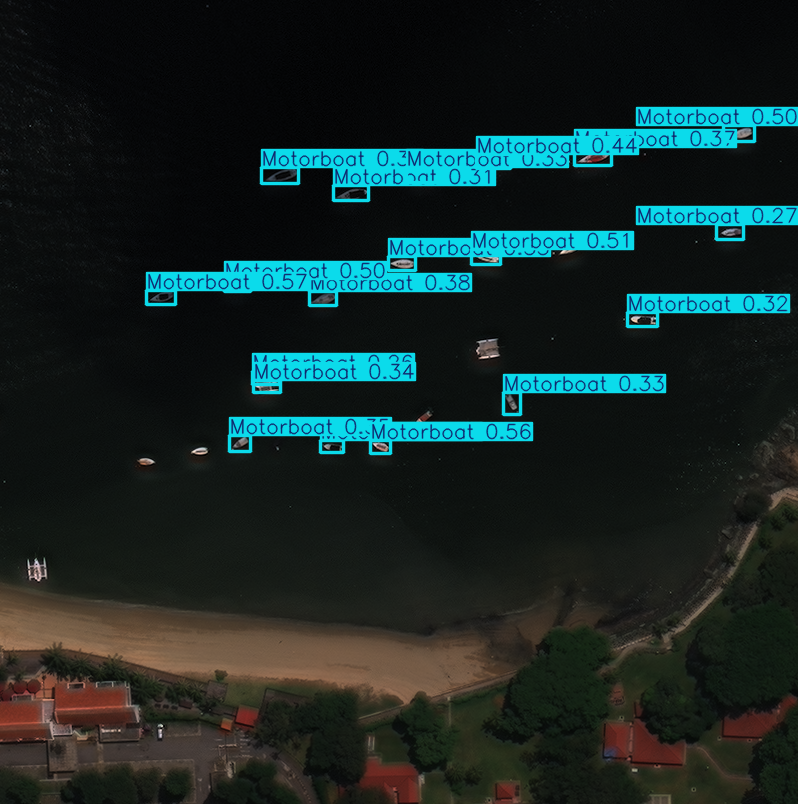

In [12]:
# metrics = model.val()
results = model("/content/drive/MyDrive/ShipClassfication/EO_Val_Split/1118_4x4_1.tif", imgsz='640')
results[0].show()